## kmeans를 이용한 state 군집화

In [30]:
# kmeans 사용 시 메모리 누수 방지
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [31]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import datetime

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
%matplotlib inline
import plotly.express as px

# 데이터 로드
from glob import glob

# tqdm
from tqdm import tqdm

# kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import kelbow_visualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
# 과학적 표기법 변환
pd.options.display.float_format = '{:.5f}'.format

In [33]:
# 파일 탐색
root_dir = "data/olist"
glob(f"{root_dir}/*.csv")

['data/olist\\complete_orders.csv',
 'data/olist\\olist_customers_dataset.csv',
 'data/olist\\olist_geolocation_dataset.csv',
 'data/olist\\olist_orders_dataset.csv',
 'data/olist\\olist_order_items_dataset.csv',
 'data/olist\\olist_order_payments_dataset.csv',
 'data/olist\\olist_order_reviews_dataset.csv',
 'data/olist\\olist_order_reviews_dataset_trans.csv',
 'data/olist\\olist_order_reviews_dataset_trans_en.csv',
 'data/olist\\olist_products_dataset.csv',
 'data/olist\\olist_sellers_dataset.csv',
 'data/olist\\product_category_name_translation.csv']

In [34]:
# 데이터 로드
df = pd.read_csv(f"{root_dir}/complete_orders.csv", 
                 parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
                              "order_delivered_customer_date", "shipping_limit_date"])
display(df.head())
df.shape

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
2  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
3  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
4  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-08-15 18:29:31 2017-08-15 20:05:16   
2    delivered      2017-08-02 18:24:47 2017-08-02 18:43:15   
3    delivered      2017-10-23 23:26:46 2017-10-25 02:14:11   
4    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-08-17 15:28:33           2017-08-18 14:44:43   
2          2017-08-04 17:35:43           2017-08-07 18:30:01   
3          2017-10-27 16:48:46           2017-11-07 18:04:59   
4          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1           2017-08-28 00:00:00  3a51803cc0d012c3b5dc8b7528cb05f7   
2           2017-08-15 00:00:00  ef0996a1a279c26e7ecbd737be23d235   
3           2017-11-13 00:00:00  e781fdcc107d13d865fc7698711cc572   
4           2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   

   zip_code_prefix_customer  ... geolocation_lng_seller order_item_id  \
0                      3149  ...              -46.44255             1   
1                      3366  ...              -46.44255             1   
2                      2290  ...              -46.44255             1   
3                     88032  ...              -46.44255             1   
4                     47813  ...              -43.98402             1   

                         product_id  shipping_limit_date     price  \
0  87285b34884572647811a353c7ac498a  2017-10-06 11:07:15  29.99000   
1  87285b34884572647811a353c7ac498a  2017-08-21 20:05:16  29.99000   
2  87285b34884572647811a353c7ac498a  2017-08-08 18:37:31  29.99000   
3  87285b34884572647811a353c7ac498a  2017-10-31 02:14:11  29.99000   
4  595fac2a385ac33a80bd5114aec74eb8  2018-07-30 03:24:27 118.70000   

   freight_value review_score payment_type  payment_installments  \
0        8.72000            4      voucher                     1   
1        7.78000            4  credit_card                     3   
2        7.78000            5  credit_card                     1   
3       14.10000            3       boleto                     1   
4       22.76000            4       boleto                     1   

   product_category_name_english  
0                     housewares  
1                     housewares  
2                     housewares  
3                     housewares  
4                      perfumery  

[5 rows x 29 columns]

(92657, 29)

In [35]:
# 위경도 잘못된 것 정리
df = df[df["geolocation_lat_customer"] <= 5.27438888]
df = df[df["geolocation_lng_customer"] >= -73.98283055]
df = df[df["geolocation_lat_customer"] >= -33.75116944]
df = df[df["geolocation_lng_customer"] <=  -34.79314722]
df.shape

(92653, 29)

In [36]:
# 배송 시간 파생변수 생성
df["delivery_time"] = df["order_delivered_customer_date"] - df["order_purchase_timestamp"]

In [37]:
# 배송시간 100일 이상인 것 정리
print(df.shape)
df = df[df['delivery_time'] < datetime.timedelta(days=100)]
df.shape

(92653, 30)


(92591, 30)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92591 entries, 0 to 92656
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       92591 non-null  object         
 1   customer_id                    92591 non-null  object         
 2   order_status                   92591 non-null  object         
 3   order_purchase_timestamp       92591 non-null  datetime64[ns] 
 4   order_approved_at              92591 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   92591 non-null  datetime64[ns] 
 6   order_delivered_customer_date  92591 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  92591 non-null  object         
 8   customer_unique_id             92591 non-null  object         
 9   zip_code_prefix_customer       92591 non-null  int64          
 10  customer_city                  92591 non-null  object         
 11  cu

## 브라질 state별 인구 정보

In [39]:
df_pop = pd.read_excel(f"{root_dir}/brazil_population_2019.xlsx", index_col="customer_state")
df_pop.head()

population
customer_state            
RO                 1777225
AC                  881935
AM                 4144597
RO                  605761
PA                 8602865

In [40]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, RO to DF
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   population  27 non-null     int64
dtypes: int64(1)
memory usage: 432.0+ bytes


## 주별 피처 생성
- order_id로 count 한 것과 customer_unique_id로 count 한 것은 같은 것임(== 소비자 수)

In [41]:
# 소비자 주 별 ~
df_X = df.groupby("customer_state").agg({"customer_unique_id" : "count",
                                         "seller_id" : "nunique",
                                        "freight_value" : "mean", 
                                        "delivery_time" : "mean"})
df_X.columns = ["customer_count", "seller_count", "freight_value", "delivery_time"]

# 배송시간 int형 변환
df_X["delivery_time"] = df_X["delivery_time"].astype(str).str.split().str[0].astype(int)

In [42]:
# 주별 인구 정보와 merge
df_X = df_X.merge(df_pop, left_index=True, right_index=True).copy()
df_X.head()

customer_count  seller_count  freight_value  delivery_time  \
customer_state                                                               
AC                          74            65       42.07878             21   
AL                         385           238       36.35332             24   
AM                         141           113       33.42766             25   
AP                          65            60       35.31492             24   
BA                        3114           901       26.27838             18   

                population  
customer_state              
AC                  881935  
AL                 3337357  
AM                 4144597  
AP                  845731  
BA                14873064

In [43]:
# 값의 스케일이 다르므로 스케일링
# 인구, 소비자 수, 판매자 수는 standradscaler 사용
# 나머지는 이상치가 존재하는 것으로 판단해 이상치에 덜 민감한 minmax 사용
mm = MinMaxScaler()
ss = StandardScaler()

df_X["population_scale"] = ss.fit_transform(df_X[["population"]])
df_X["customer_count_scale"] = ss.fit_transform(df_X[["customer_count"]])
df_X["seller_count_scale"] = ss.fit_transform(df_X[["seller_count"]])
df_X["freight_value_scale"] = mm.fit_transform(df_X[["freight_value"]])
df_X["delivery_time_scale"] = mm.fit_transform(df_X[["delivery_time"]])

In [44]:
# kmeans에 학습할 피처 추출
X = df_X[["population_scale", "customer_count_scale", "seller_count_scale", "freight_value_scale", "delivery_time_scale"]].copy()
X.head()

population_scale  customer_count_scale  seller_count_scale  \
customer_state                                                               
AC                      -0.76019              -0.44350            -0.99981   
AL                      -0.48972              -0.40248            -0.68427   
AM                      -0.40080              -0.43466            -0.91226   
AP                      -0.76418              -0.44469            -1.00893   
BA                       0.78096              -0.04254             0.52504   

                freight_value_scale  delivery_time_scale  
customer_state                                            
AC                          0.97666              0.76471  
AL                          0.76790              0.94118  
AM                          0.66123              1.00000  
AP                          0.73004              0.94118  
BA                          0.40056              0.58824

- Inertia value는 군집화가된 후에, 각 중심점에서 군집의 데이타간의 거리를 합산한 것이므로 군집의 응집도를 나타내는 값임. 이 값이 작을 수록 응집도가 높게 군집화가 잘되었다고 평가할 수 있음
  - 데이터간의 거리는 유클리디안 거리로 계산

In [45]:
# 최적의 k 구하기
inertia = []
silhouettes = []
range_n_clusters = range(2, 11)
for i in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.63it/s]


In [46]:
# 클러스터 개수 별 SSE 값 직접 구하기
pd.DataFrame({"NumberofCluster":range_n_clusters, "Error":inertia})

NumberofCluster    Error
0                2 32.49208
1                3 10.90657
2                4  6.23589
3                5  3.67511
4                6  2.43499
5                7  2.00140
6                8  1.60425
7                9  1.28254
8               10  1.03096

- elbow method : 군집 내 거리 제곱합의 그래프가 급격히 완만해지는 지점의 k 값을 최적의 군집 개수로 선택
  - 값이 작을수록 더 적합한 클러스터임
- Silhouette Method : 군집 내 응집도와 군집 간 거리를 계산하여 나온 실루엣 계수를 통해 최적의 군집 개수 파악
  - 실루엣 계수의 평균값이 1에 가까울수록 군집화가 잘 되었다고 생각할 수 있음.

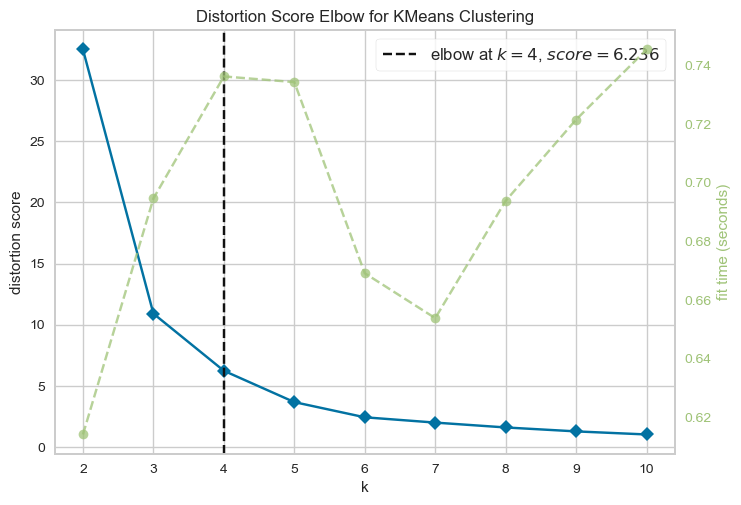

In [47]:
# elbow method 사용. elbow point(k값) 도출
kelbow_visualizer(kmeans, X, k=10);

### 직접 검증
- yellowbrick api를 사용했을 때 k=4로 나오지만, 직접 SSE 값과 실루엣 계수를 구해서 검증
- k=4로 결과가 똑같음

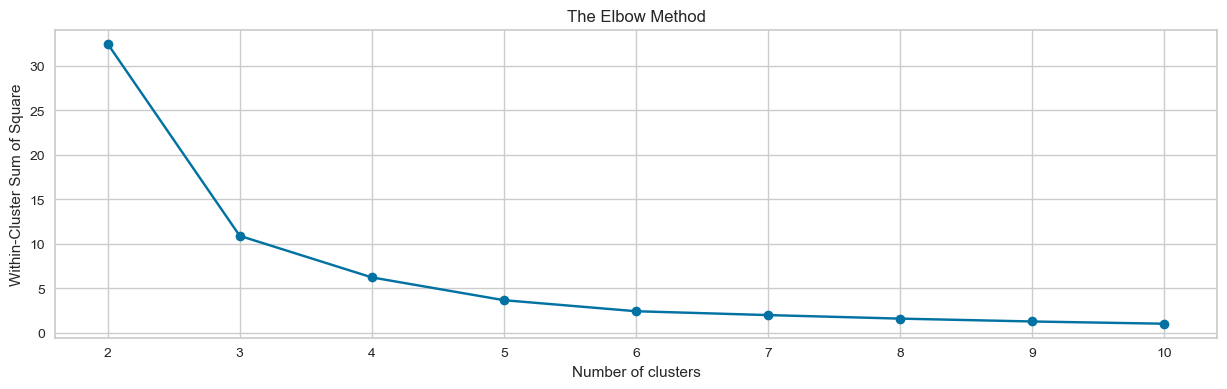

In [48]:
# elbow method
plt.figure(figsize=(15,4))
plt.plot(range_n_clusters, inertia, "-o")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.xticks(range_n_clusters)
plt.show()

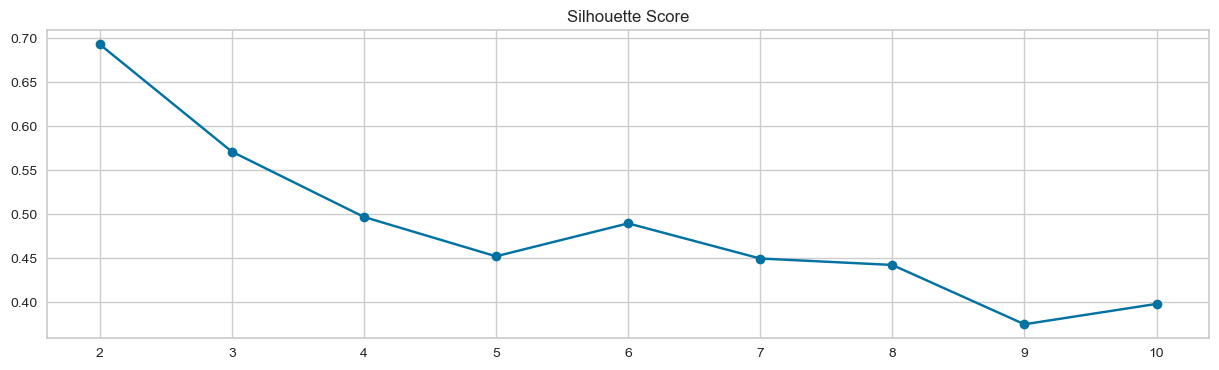

In [49]:
# 실루엣 스코어 시각화
plt.figure(figsize=(15, 4))
plt.title('Silhouette Score')
plt.plot(range_n_clusters, silhouettes, "-o")
plt.xticks(range_n_clusters)
plt.show()

In [50]:
# 도출한 k값으로 클러스터링
n_cluster = 4

kmeans = KMeans(n_clusters=n_cluster, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [51]:
# 클러스터 번호 부여
df_X["cluster"] = kmeans.predict(X)
X["cluster"] = kmeans.predict(X)
df_X = df_X.reset_index()

population_scale  customer_count_scale  seller_count_scale  \
customer_state                                                               
SP                       4.20072               4.69510             3.18988   
MS                      -0.55123              -0.36305            -0.40884   
SE                      -0.60413              -0.41013            -0.74628   
RS                       0.39589               0.22560             0.99198   
SC                      -0.06812              -0.00443             0.66366   

                freight_value_scale  delivery_time_scale  cluster  
customer_state                                                     
SP                          0.00000              0.00000        1  
MS                          0.31649              0.41176        0  
SE                          0.77069              0.70588        0  
RS                          0.23888              0.41176        2  
SC                          0.24018              0.35294        2

In [56]:
# 클러스터 내 중심점
centers = kmeans.cluster_centers_
X.sample(5)

population_scale  customer_count_scale  seller_count_scale  \
customer_state                                                               
RJ                       1.04443               1.10810             1.85108   
PE                       0.19539              -0.25080            -0.03493   
PR                       0.40213               0.17073             1.01204   
SP                       4.20072               4.69510             3.18988   
AM                      -0.40080              -0.43466            -0.91226   

                freight_value_scale  delivery_time_scale  cluster  
customer_state                                                     
RJ                          0.21369              0.41176        3  
PE                          0.63339              0.58824        2  
PR                          0.18826              0.23529        2  
SP                          0.00000              0.00000        1  
AM                          0.66123              1.00000        0

## 시각화 및 클러스터별 특징 확인

<Figure size 2000x2000 with 0 Axes>

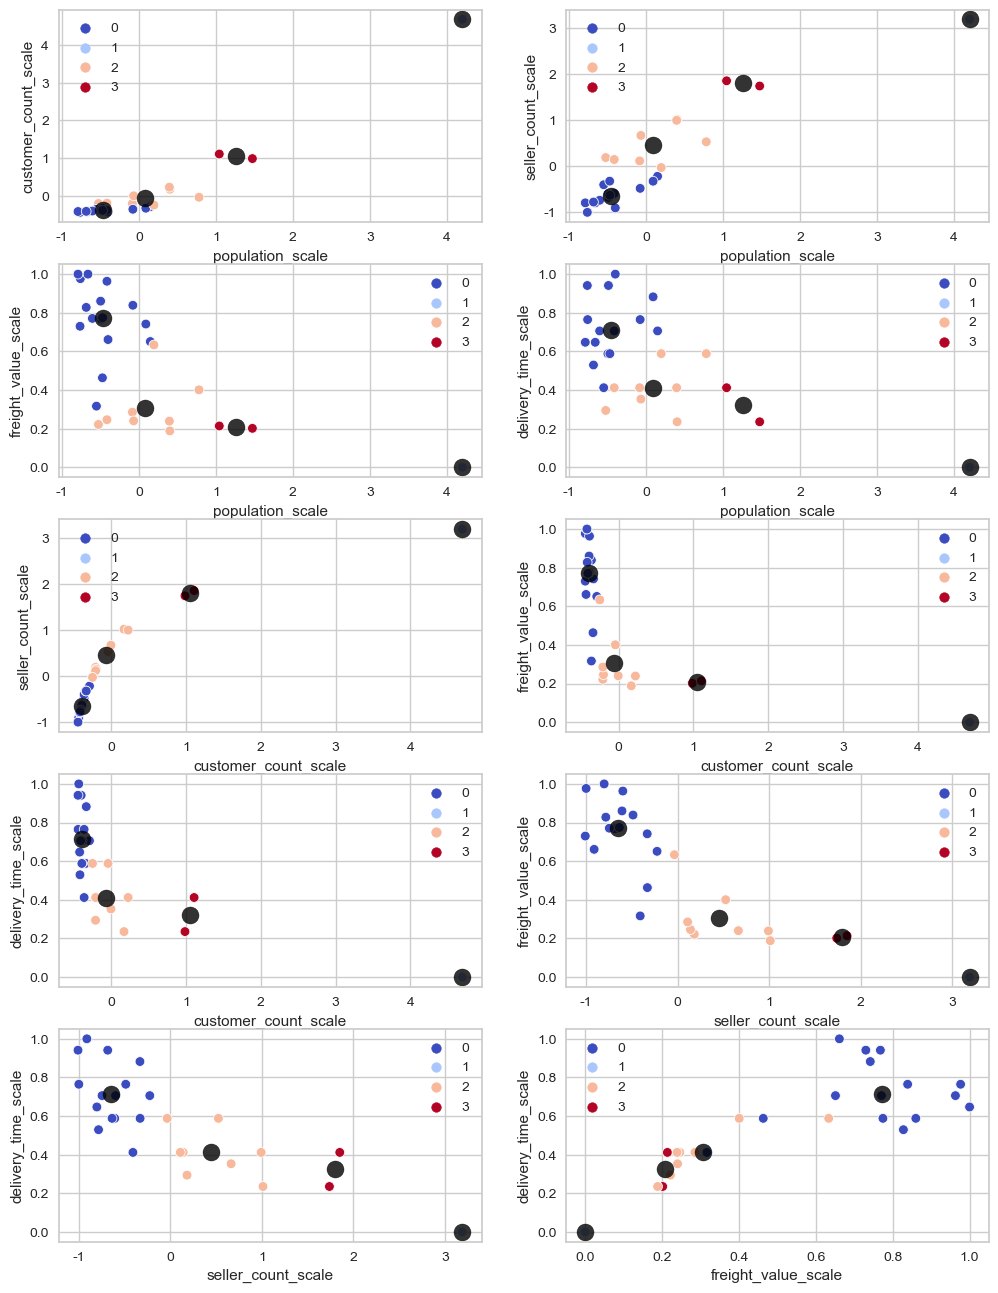

In [61]:
# 2차원으로 시각화 - 차원 간 비교
plt.figure(figsize=(20, 20))
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 16))

sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[0,0])
axes[0,0].scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[0,1])
axes[0,1].scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[1,0])
axes[1,0].scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[1,1])
axes[1,1].scatter(centers[:,0], centers[:,4], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,2], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[2,0])
axes[2,0].scatter(centers[:,1], centers[:,2], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,3], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[2,1])
axes[2,1].scatter(centers[:,1], centers[:,3], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,4], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[3,0])
axes[3,0].scatter(centers[:,1], centers[:,4], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,2], y=X.iloc[:,3], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[3,1])
axes[3,1].scatter(centers[:,2], centers[:,3], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,2], y=X.iloc[:,4], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[4,0])
axes[4,0].scatter(centers[:,2], centers[:,4], c='black', alpha=0.8, s=150)

sns.scatterplot(x=X.iloc[:,3], y=X.iloc[:,4], data=X, hue=kmeans.labels_, palette='coolwarm', ax=axes[4,1])
axes[4,1].scatter(centers[:,3], centers[:,4], c='black', alpha=0.8, s=150)

plt.show()

In [24]:
# 3차원으로 시각화
# plt.figure(figsize=(8, 8))
# ax = plt.axes(projection='3d')

# # 데이터 scatterplot
# ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=X["cluster"], s=10, cmap="rainbow", alpha=1)

# # centroid scatterplot
# ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=200, marker='*')

# plt.show()

In [62]:
col = ["customer_state", "population_scale", 
 "customer_count_scale", "seller_count_scale", 
 "freight_value_scale", "delivery_time_scale", "cluster"]

In [69]:
# 군집별 특징 확인
df_X.groupby("cluster")[col[:-1]].mean()

population_scale  customer_count_scale  seller_count_scale  \
cluster                                                               
0                -0.46261              -0.39170            -0.64801   
1                 4.20072               4.69510             3.18988   
2                 0.08527              -0.06525             0.44866   
3                 1.25943               1.04704             1.79453   

         freight_value_scale  delivery_time_scale  
cluster                                            
0                    0.77145              0.71324  
1                    0.00000              0.00000  
2                    0.30676              0.41176  
3                    0.20755              0.32353

## 클러스터 내 state 확인

In [26]:
df_X["cluster"].value_counts()

0    16
2     8
3     2
1     1
Name: cluster, dtype: int64

In [65]:
df_X.loc[df_X["cluster"] == 1, col]

customer_state  population_scale  customer_count_scale  seller_count_scale  \
25             SP           4.20072               4.69510             3.18988   

    freight_value_scale  delivery_time_scale  cluster  
25              0.00000              0.00000        1

In [63]:
df_X.loc[df_X["cluster"] == 3, col]

customer_state  population_scale  customer_count_scale  seller_count_scale  \
10             MG           1.47444               0.98597             1.73799   
18             RJ           1.04443               1.10810             1.85108   

    freight_value_scale  delivery_time_scale  cluster  
10              0.20140              0.23529        3  
18              0.21369              0.41176        3

In [67]:
df_X.loc[df_X["cluster"] == 2, col]

customer_state  population_scale  customer_count_scale  seller_count_scale  \
4              BA           0.78096              -0.04254             0.52504   
6              DF          -0.52520              -0.21005             0.18213   
7              ES          -0.41467              -0.20121             0.14018   
8              GO          -0.08425              -0.20926             0.10917   
15             PE           0.19539              -0.25080            -0.03493   
17             PR           0.40213               0.17073             1.01204   
22             RS           0.39589               0.22560             0.99198   
23             SC          -0.06812              -0.00443             0.66366   

    freight_value_scale  delivery_time_scale  cluster  
4               0.40056              0.58824        2  
6               0.22156              0.29412        2  
7               0.24597              0.41176        2  
8               0.28530              0.41176        2  
15              0.63339              0.58824        2  
17              0.18826              0.23529        2  
22              0.23888              0.41176        2  
23              0.24018              0.35294        2

In [66]:
df_X.loc[df_X["cluster"] == 0, col]

customer_state  population_scale  customer_count_scale  seller_count_scale  \
0              AC          -0.76019              -0.44350            -0.99981   
1              AL          -0.48972              -0.40248            -0.68427   
2              AM          -0.40080              -0.43466            -0.91226   
3              AP          -0.76418              -0.44469            -1.00893   
5              CE           0.14858              -0.29116            -0.22462   
9              MA          -0.07799              -0.36278            -0.48727   
11             MS          -0.55123              -0.36305            -0.40884   
12             MT          -0.47352              -0.34142            -0.33041   
13             PA           0.09028              -0.33456            -0.33224   
14             PB          -0.41473              -0.38850            -0.59854   
16             PI          -0.49678              -0.39365            -0.60766   
19             RN          -0.47105              -0.39312            -0.63684   
20             RO          -0.66157              -0.42253            -0.80282   
21             RO          -0.79061              -0.42253            -0.80282   
24             SE          -0.60413              -0.41013            -0.74628   
26             TO          -0.68408              -0.41844            -0.78458   

    freight_value_scale  delivery_time_scale  cluster  
0               0.97666              0.76471        0  
1               0.76790              0.94118        0  
2               0.66123              1.00000        0  
3               0.73004              0.94118        0  
5               0.65102              0.70588        0  
9               0.83884              0.76471        0  
11              0.31649              0.41176        0  
12              0.46308              0.58824        0  
13              0.74162              0.88235        0  
14              0.96319              0.70588        0  
16              0.86011              0.58824        0  
19              0.77452              0.58824        0  
20              1.00000              0.64706        0  
21              1.00000              0.64706        0  
24              0.77069              0.70588        0  
26              0.82781              0.52941        0

- 한계 : 여러 군집 분석을 이용해 보팅을 하고 싶었으나 피처의 개수가 적어 결과가 비슷하게 나올 것이라고 판단했고 시간적 여유도 부족했음